In [36]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import pickle 




In [2]:
df_path = '~/Documents/GitHub/metis_coursework/project_1/data/Turnstile_Usage_Data__2019.csv' #your own path of the file
#df_path = '~/Documents/GitHub/Metis_project1/Turnstile_Usage_Data__2019.csv'

df = pd.read_csv(df_path,header = 0)

In [3]:
#simple understanding of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10467101 entries, 0 to 10467100
Data columns (total 11 columns):
C/A                                                           object
Unit                                                          object
SCP                                                           object
Station                                                       object
Line Name                                                     object
Division                                                      object
Date                                                          object
Time                                                          object
Description                                                   object
Entries                                                       int64
Exits                                                         int64
dtypes: int64(2), object(9)
memory usage: 878.4+ MB


In [4]:
df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A033,R170,02-06-00,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,769115,559221
1,A033,R170,02-00-04,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,6483080,4945335
2,A033,R170,02-00-03,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,7191422,8417203
3,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,14983900,14554087
4,A033,R170,02-06-01,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,71047673,20925389


In [3]:
#create unique turnstile id for each turnstile
df['Turnstile_ID'] = df['Unit'].astype(str) + "_"+ df['SCP'].astype(str) +"_"+ df['Station'].astype(str) 

In [4]:
#clean up column name
df.rename(columns = {'Exits                                                     ':'Exits'},inplace = True)

In [5]:
#trim dataset so that it runs faster
columns_to_keep = ['Turnstile_ID','Station','Date','Time','Entries','Exits']
df_new = pd.DataFrame(df[columns_to_keep])

In [6]:
#convert date and time into datetime format
df_new['Date'] = df_new.Date.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
df_new['Time'] = df_new.Time.apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').time())

In [7]:
df_new.head()

,Turnstile_ID,Station,Date,Time,Entries,Exits
0,R170_02-06-00_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,769115,559221
1,R170_02-00-04_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,6483080,4945335
2,R170_02-00-03_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,7191422,8417203
3,R170_02-00-02_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,14983900,14554087
4,R170_02-06-01_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,71047673,20925389


In [8]:
df_new = df_new.sort_values(by = ['Turnstile_ID','Date']).reset_index()

In [9]:
#calculate incremental of entry and exit
df_new['Entry_diff'] = np.where(df_new.Entries > df_new.Entries.shift(periods = 1,fill_value = 0),df_new.Entries.diff(periods = 1),df_new.Entries.values)
df_new['Exit_diff'] = np.where(df_new.Exits > df_new.Exits.shift(periods = 1,fill_value = 0),df_new.Exits.diff(periods = 1),df_new.Exits.values)

In [10]:
#reset to zero for different turnstiles
df_new['Entry_diff'] = np.where(df_new.Turnstile_ID == df_new.Turnstile_ID.shift(periods = 1,fill_value = 0),
                                df_new.Entry_diff,0)

In [11]:
df_new['Exit_diff'] = np.where(df_new.Turnstile_ID == df_new.Turnstile_ID.shift(periods = 1,fill_value = 0),
                               df_new.Exit_diff,0)

In [31]:
df_new[df_new['Turnstile_ID'] == 'R001_00-00-00_WHITEHALL S-FRY'][-1:]#test if the resetting according to tunrstile is working

,index,Turnstile_ID,Station,Date,Time,Entries,Exits,Entry_diff,Exit_diff
2192,24700,R001_00-00-00_WHITEHALL S-FRY,WHITEHALL S-FRY,2019-12-27,20:00:00,4876442,2850177,798.0,303.0


In [32]:
df_new[df_new['Turnstile_ID'] == 'R001_00-00-01_WHITEHALL S-FRY'][:1]

,index,Turnstile_ID,Station,Date,Time,Entries,Exits,Entry_diff,Exit_diff
2193,10438615,R001_00-00-01_WHITEHALL S-FRY,WHITEHALL S-FRY,2018-12-29,00:00:00,3219391,2084003,0.0,0.0


In [33]:
df_new['Net_Flow'] = df_new['Entry_diff'] + df_new['Exit_diff']

In [34]:
columns_to_keep = ['Turnstile_ID','Station','Date','Time','Net_Flow']
df_new = pd.DataFrame(df_new[columns_to_keep])

In [44]:
df_new.head()
df_new.to_pickle('./data_clean.pkl') # pickle the DF

In [46]:
unpickled_df = pd.read_pickle('./data_clean.pkl') #test if pickle works
unpickled_df.head()

,Turnstile_ID,Station,Date,Time,Net_Flow
0,R001_00-00-00_WHITEHALL S-FRY,WHITEHALL S-FRY,2018-12-29,00:00:00,0.0
1,R001_00-00-00_WHITEHALL S-FRY,WHITEHALL S-FRY,2018-12-29,04:00:00,79.0
2,R001_00-00-00_WHITEHALL S-FRY,WHITEHALL S-FRY,2018-12-29,08:00:00,198.0
3,R001_00-00-00_WHITEHALL S-FRY,WHITEHALL S-FRY,2018-12-29,12:00:00,638.0
4,R001_00-00-00_WHITEHALL S-FRY,WHITEHALL S-FRY,2018-12-29,16:00:00,988.0


In [47]:
#Station flow per year
station_flow = df_new.groupby(by = 'Station')['Net_Flow'].sum()

In [48]:
station_flow.sort_values(ascending = False,inplace = True)
station_flow.index[:20]

Index(['14 ST', '104 ST', '42 ST-PORT AUTH', 'BAY PKWY', 'ELMHURST AV',
       '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '61 ST WOODSIDE',
       'GRD CNTRL-42 ST', '18 AV', '161/YANKEE STAD', '190 ST', '23 ST',
       'DEKALB AV', 'FLATBUSH AV-B.C', '59 ST', 'FULTON ST', 'COURT SQ',
       'KINGS HWY', 'B'WAY-LAFAYETTE'],
      dtype='object', name='Station')

Text(0.5, 1.0, 'Annual passenger flow per station')

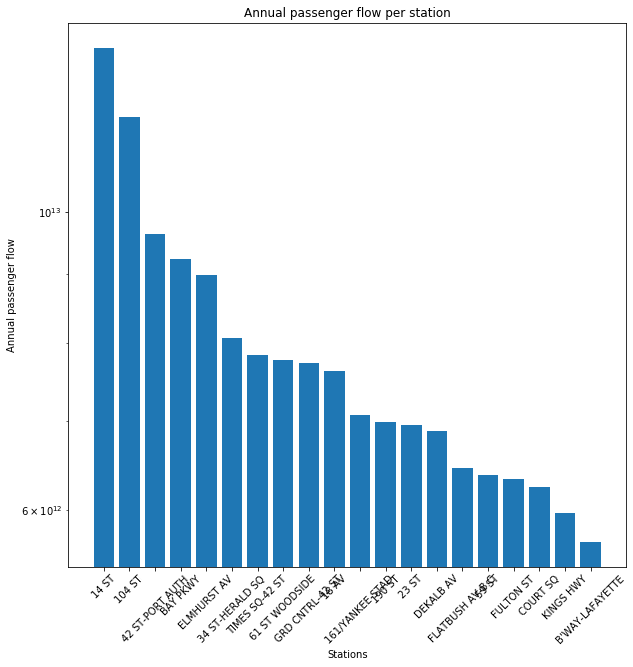

In [49]:

plt.figure(figsize=[10,10])
plt.bar(x = station_flow.index[:20],height = station_flow[:20],log = True)
plt.xticks(np.arange(20),station_flow.index[:20],rotation=45)
plt.xlabel('Stations')
plt.ylabel('Annual passenger flow')
plt.title('Annual passenger flow per station')

In [50]:
#Station flow per day
station_flow_day = station_flow / len(df_new.Date.unique())

Text(0.5, 1.0, 'Average flow per station per day')

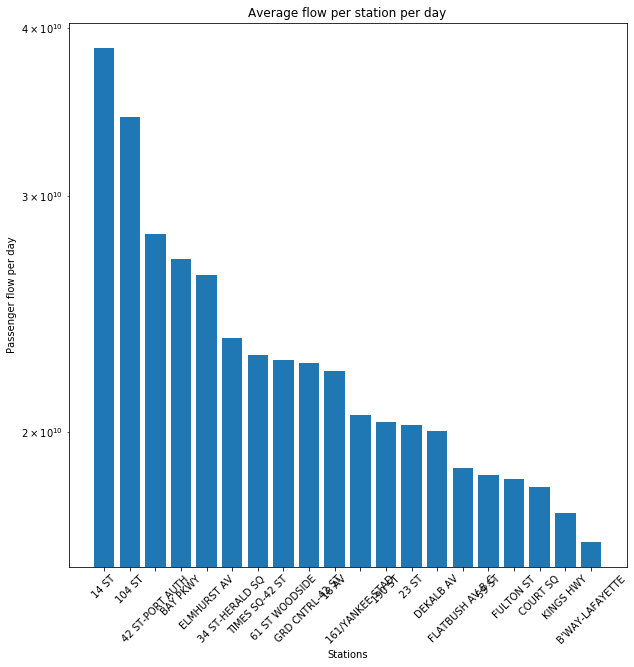

In [51]:
plt.figure(figsize=[10,10])
plt.bar(x = station_flow_day.index[:20],height = station_flow_day[:20],log = True)
plt.xticks(np.arange(20),station_flow_day.index[:20],rotation=45)
plt.xlabel('Stations')
plt.ylabel('Passenger flow per day')
plt.title('Average flow per station per day')

343